In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
import glob

from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/ml/reduced_vm.csv")

In [ ]:
path = "/content/gdrive/MyDrive/ml/faststore"
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter=";")
    #if (len(df[df['\tCPU cores']])/df.shape[0] < 0.7):
    li.append(df)

new_df = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,4,11703.998240,10912.027692,93.233333,67108864.0,6.129274e+06,0.133333,15981.600000,0.000000,2.133333
1,1376315146,4,11703.998240,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,0.000000,2.600000
2,1376315446,4,11703.998240,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,535.666667,23.933333
3,1376315746,4,11703.998240,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,349.666667,5.466667
4,1376316046,4,11703.998240,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,0.000000,2.066667
...,...,...,...,...,...,...,...,...,...,...,...
9073636,1378905598,4,9599.998716,0.000000,0.000000,522288.0,2.306640e+04,0.000000,0.000000,0.000000,0.000000
9073637,1378905898,4,9599.998716,0.000000,0.000000,522288.0,2.131893e+04,0.000000,0.000000,0.000000,0.000000
9073638,1378906198,4,9599.998716,0.000000,0.000000,522288.0,1.502880e+04,0.000000,0.000000,0.000000,0.000000
9073639,1378906498,4,9599.998716,0.000000,0.000000,522288.0,1.747360e+04,0.000000,0.000000,0.000000,0.000000


In [ ]:
df = df[['Timestamp [ms]', 'CPU usage [MHZ]']] # "Memory usage [KB]"
df = df.sort_values("Timestamp [ms]")
df = df.groupby("Timestamp [ms]").mean()

In [ ]:
df

,CPU usage [MHZ]
Timestamp [ms],
1376314846,639.632054
1376315146,737.429794
1376315446,690.064562
1376315746,573.742385
1376316046,559.744521
...,...
1378906198,1185.984316
1378906421,19.066664
1378906498,1163.354251


In [ ]:
for i in range(1,50):
    df[f" {i}diff"] = df["CPU usage [MHZ]"].diff(i)

df = df.dropna()

In [ ]:
x = df.drop(["CPU usage [MHZ]"], axis=1)
y = df['CPU usage [MHZ]']

In [ ]:
x

,1diff,2diff,3diff,4diff,5diff,6diff,7diff,8diff,9diff,10diff,...,40diff,41diff,42diff,43diff,44diff,45diff,46diff,47diff,48diff,49diff
Timestamp [ms],,,,,,,,,,,,,,,,,,,,,
1376329547,91.131040,72.717385,-2.536079,-150.815723,-110.244528,-25.762034,20.166011,13.553034,-21.337377,-162.619161,...,626.068860,712.505879,685.813762,541.570882,587.526170,619.249235,605.251371,488.929195,441.563962,539.361703
1376329847,36.604529,127.735569,109.321914,34.068450,-114.211194,-73.639998,10.842495,56.770540,50.157563,15.267152,...,661.009239,662.673389,749.110408,722.418291,578.175412,624.130699,655.853765,641.855900,525.533724,478.168491
1376330147,-2.007063,34.597466,125.728506,107.314851,32.061387,-116.218257,-75.647062,8.835432,54.763477,48.150500,...,735.679796,659.002176,660.666326,747.103345,720.411228,576.168348,622.123636,653.846701,639.848837,523.526661
1376330447,-29.866328,-31.873392,4.731138,95.862178,77.448523,2.195059,-146.084585,-105.513390,-21.030896,24.897149,...,725.786294,705.813468,629.135848,630.799998,717.237017,690.544900,546.302020,592.257308,623.980373,609.982509
1376330747,-72.811350,-102.677678,-104.684741,-68.080212,23.050828,4.637173,-70.616291,-218.895935,-178.324739,-93.842246,...,603.715064,652.974944,633.002118,556.324498,557.988648,644.425667,617.733550,473.490670,519.445958,551.169023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378906198,1161.717653,-40.470485,1159.984320,-82.440972,1163.450986,-469.776240,1161.717653,-528.402606,1159.984320,-550.373928,...,1159.984320,-316.300619,1159.984320,39.384320,1159.984320,248.826628,1161.717653,251.097319,1159.984320,245.795538
1378906421,-1166.917653,-5.199999,-1207.388137,-6.933332,-1249.358625,-3.466666,-1636.693893,-5.199999,-1695.320258,-6.933332,...,-1512.046192,-6.933332,-1483.218272,-6.933332,-1127.533332,-6.933332,-918.091025,-5.199999,-915.820334,-6.933332
1378906498,1144.287587,-22.630065,1139.087588,-63.100550,1137.354255,-105.071038,1140.820921,-492.406305,1139.087588,-551.032671,...,1137.354255,-367.758604,1137.354255,-338.930684,1137.354255,16.754255,1137.354255,226.196563,1139.087588,228.467254


In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
#df_scaled = pd.DataFrame(transformed, columns=df.columns)

In [ ]:
train = x[:(int(x.shape[0] * 0.9))]
test = x[-(int(x.shape[0] * 0.1)):]

y_train = y.head(int(y.shape[0] * 0.9))
y_test = y.tail(int(y.shape[0] * 0.1))

In [ ]:
train.shape, y_train.shape, test.shape, y_test.shape

((10126, 49), (10126,), (1125, 49), (1125,))

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 1000 # 300ms * 1000 timesteps = 5 mins

In [ ]:
X_train, y_train = create_dataset(pd.DataFrame(train), y_train, time_steps)
X_test, y_test = create_dataset(pd.DataFrame(test), y_test, time_steps)

X_train.shape, X_test.shape

((9126, 1000, 49), (125, 1000, 49))

In [ ]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(units=120, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model1.add(Bidirectional(LSTM(units=120)))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))
model1.compile(loss='mean_squared_error', optimizer=Adam(0.01))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
history1 = model1.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_split=0.1,
    shuffle=False,
    callbacks=[callback],
)

Epoch 1/40
129/129 [==============================] - 39s 216ms/step - loss: 996362.5625 - val_loss: 263325.0312
Epoch 2/40
129/129 [==============================] - 25s 196ms/step - loss: 748323.2500 - val_loss: 222313.6875
Epoch 3/40
129/129 [==============================] - 26s 199ms/step - loss: 602777.2500 - val_loss: 233648.6875
Epoch 4/40
129/129 [==============================] - 26s 198ms/step - loss: 525714.8750 - val_loss: 265500.8125
Epoch 5/40
129/129 [==============================] - 26s 201ms/step - loss: 487890.6875 - val_loss: 299503.2188
Epoch 6/40
129/129 [==============================] - 26s 200ms/step - loss: 469668.5625 - val_loss: 327824.9688
Epoch 7/40
129/129 [==============================] - 26s 198ms/step - loss: 461160.6562 - val_loss: 348540.5000
Epoch 8/40
129/129 [==============================] - 26s 200ms/step - loss: 457122.6562 - val_loss: 362635.2500
Epoch 9/40
129/129 [==============================] - 26s 200ms/step - loss: 455589.0625 - val_l

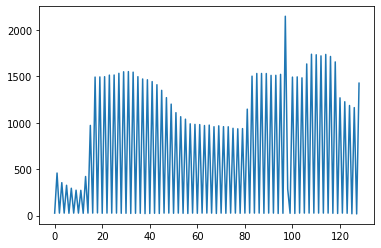

In [ ]:
plt.plot(y_test)

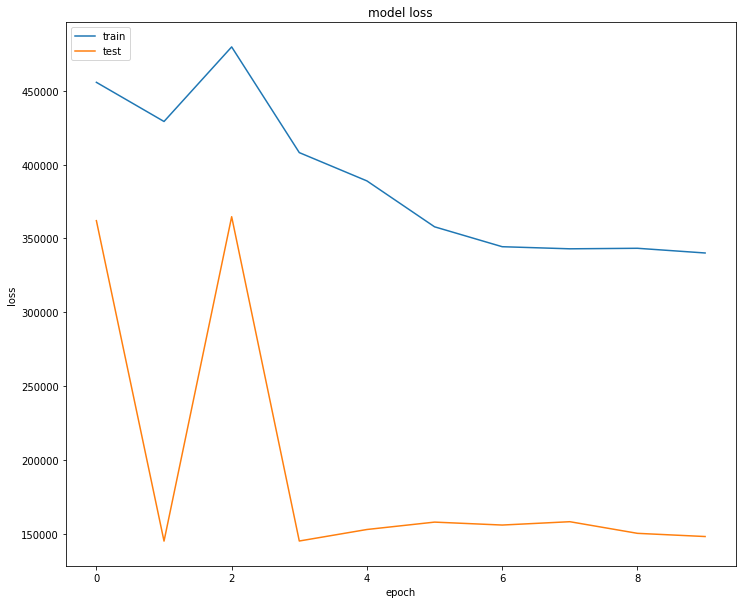

In [ ]:
plt.figure(figsize =  (12,10))
# summarize history for accuracy
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tf_predict = model1.predict(X_test)

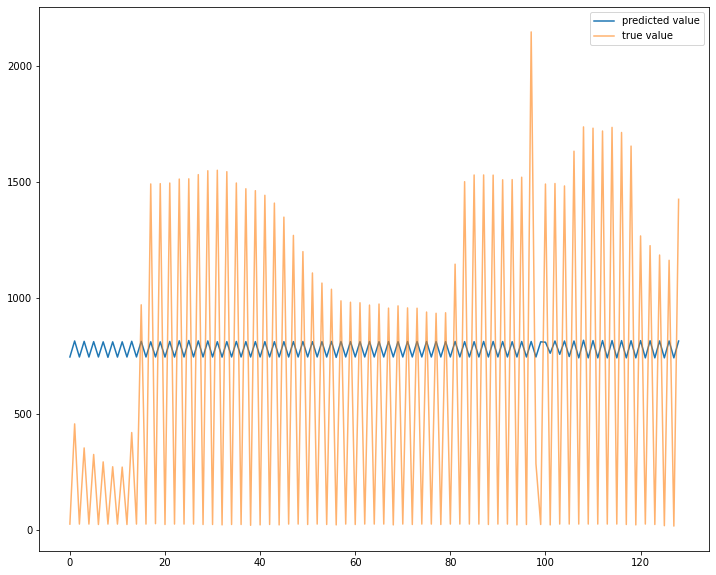

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(tf_predict)
plt.plot(y_test, alpha=0.6)
plt.legend(["predicted value", "true value"])

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor()

In [ ]:
lgbm.fit(train, y_train)

LGBMRegressor()

In [ ]:
preds = lgbm.predict(test)

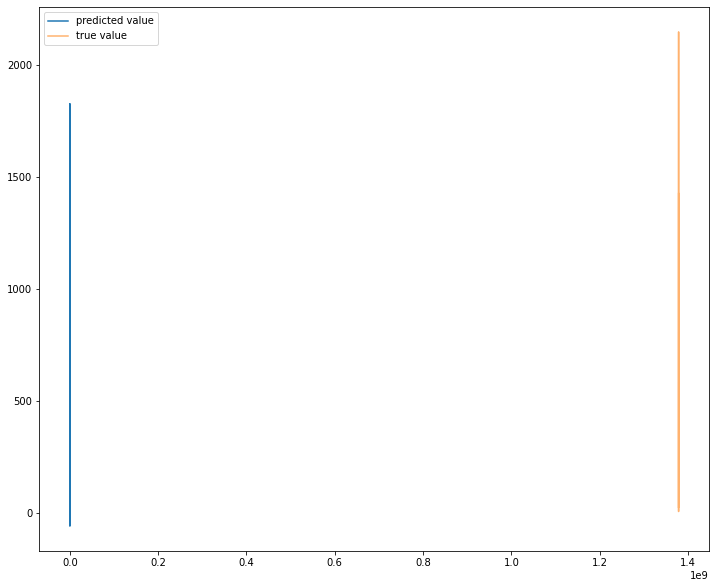

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(preds)
plt.plot(y_test, alpha=0.6)
plt.legend(["predicted value", "true value"])

In [ ]:
pm1 = {
    "num_cores": 8,
    "cpu_freq": 2266,
    "power_consume": [260, 380, 436, 474, 509, 546, 587, 629, 669, 710, 748]
}

pm2 = {
    "num_cores": 12,
    "cpu_freq": 2933,
    "power_consume": [204, 315, 340, 361, 387, 419, 457, 494, 530, 562, 596]
}

pm3 = {
    "num_cores": 12,
    "cpu_freq": 2933,
    "power_consume": [62.3, 105, 119, 130, 142, 153, 164, 181, 200, 220, 244]
}

pm4 = {
    "num_cores": 8,
    "cpu_freq": 2200,
    "power_consume": [53.8, 77.1, 87.4, 98,4, 112, 122, 140, 160, 177, 199, 230]
}

pm5 = {
    "num_cores": 8,
    "cpu_freq": 2400,
    "power_consume": [94.6, 144, 164, 183, 200, 220, 244, 273, 315, 364, 402]
}


pc_types = [pm1, pm2, pm3, pm4, pm5]

In [ ]:
def power_consume_range(ar):
  li = []
  for v, pos in enumerate(ar):

    li.append(pos)
    if pos != ar[-1]:
      value = (ar[v+1]- pos) / 10
      next_value = pos

      for i in range(9):
        next_value += value
        li.append(next_value)

  return(li)


In [ ]:
class PM:
  def __init__(self, num_cores, cpu_freq, power_consume):
    self.num_cores = num_cores
    self.cpu_freq = cpu_freq
    self.cpu_capacity = self.num_cores * self.cpu_freq
    self.rest_capacity = self.cpu_capacity
    self.power_consume = power_consume
    self.target_load = 0
    self.power_consumtion = 0

  def calculate_cpacity(self, inbound_capacity_provisioning):
    if (self.rest_capacity > inbound_capacity_provisioning):
      self.rest_capacity -= inbound_capacity_provisioning
      self.target_load = 100 - ((self.rest_capacity/self.cpu_capacity) * 100)
      self.power_consumtion += self.power_consume[round(self.target_load)]

      dictionary = {
        "message": "VM added",
        "Rest Capacity": self.rest_capacity,
        "Power Consumption": self.power_consumtion
      }
      return dictionary

    else:

      dictionary = {
        "message": "No available space",
        "Rest Capacity": self.rest_capacity
      }
      return dictionary

In [ ]:
datacenter = []

In [ ]:
for pc in pc_types:
  for i in range(20):
    datacenter.append(PM(num_cores=pc['num_cores'], cpu_freq=pc['cpu_freq'], power_consume=power_consume_range(pc['power_consume'])))

In [ ]:
# 1000 = 5mins
# 3600000 = 1hour

class VM:
  ts = 1000
  def __init__(self, num_cores, CPU_provisioned, CPU_usage, time_of_start):
    self.num_cores = num_cores
    self.CPU_provisioned = CPU_provisioned
    self.CPU_usage = CPU_usage
    self.time_of_start = time_of_start
    self.current_time = self.time_of_start
    self.time_passed = []

  def work(self):
    my_values = []
    for i in range(1000):
      my_values.append(random.choice(self.CPU_usage))

    work_history = {
        "time_stamp": self.current_time + self.ts, # for every 5min
        "cpu_usage": my_values
    }

    self.time_passed.append(work_history)


In [ ]:
# Initializing the timespams of the VMs

nums = [1, 10, 100, 1000, ]
for i in range(1001, 1023):
  nums.append(i)

#288000 24 hours in the array
times = [0,]
value = 0
for i in range(288):
  value += 1000

  times.append(value)

In [ ]:
vms = []
choice = random.choice(nums)
counter = 0
while counter < 500:
  data = pd.read_csv(f"/content/gdrive/MyDrive/ml/faststore/{choice}.csv", delimiter=";\t")
  if data["CPU cores"].unique()[0] > 0:
    vm = VM(num_cores=data["CPU cores"].unique()[0], CPU_provisioned=data["CPU capacity provisioned [MHZ]"].unique()[0], CPU_usage=data["CPU usage [MHZ]"].unique(),
            time_of_start=random.choice(times))
    counter += 1

    vms.append(vm)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
demo_vm = vms[0]

In [ ]:
demo_vm.work()

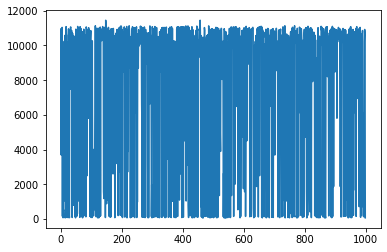

In [ ]:
plt.plot(demo_vm.time_passed[0]['cpu_usage'])

In [ ]:
129000

In [ ]:
bv = [10, 30, 40]

[value for value in range(0, 5)]


TypeError: ignored

In [ ]:
data = pd.read_csv(f"/content/gdrive/MyDrive/ml/faststore/10.csv", delimiter=";\t")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
data

,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1376315146,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1376315446,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1376315746,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1376316046,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16135,1378906392,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16136,1378906498,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16137,1378906692,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16138,1378906692,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np


In [ ]:
np.average([2,2,])

2.0